In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import pickle
from catboost import CatBoostClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

# load model
model = CatBoostClassifier()
model.load_model('../models/catboost_fraud_model.cbm')

with open('../models/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

# load results
df = pd.read_csv('../docs/two_stage_detection_results.csv')
print(f"Loaded {len(df)} transactions")
print(f"Fraud rate: {df['target'].mean()*100:.2f}%")
print(f"Features: {len(feature_names)}")

c:\Users\lengway\Desktop\lengway\ForteHackaton\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 13140 transactions
Fraud rate: 1.26%
Features: 34


## 1. Метрики модели

In [2]:
# confusion matrix
y_true = df['target']
y_pred = df['fraud_prediction']

tp = ((y_true == 1) & (y_pred == 1)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("=" * 40)
print("MODEL PERFORMANCE")
print("=" * 40)
print(f"TP: {tp} | FP: {fp}")
print(f"FN: {fn} | TN: {tn}")
print("-" * 40)
print(f"Precision: {precision:.1%}")
print(f"Recall:    {recall:.1%}")
print(f"F1-Score:  {f1:.2f}")
print("=" * 40)

MODEL PERFORMANCE
TP: 155 | FP: 16
FN: 10 | TN: 12959
----------------------------------------
Precision: 90.6%
Recall:    93.9%
F1-Score:  0.92


## 2. ROI - Бизнес-эффект

In [3]:
# calculate average fraud amount
fraud_transactions = df[df['target'] == 1]
avg_fraud_amount = fraud_transactions['amount'].mean() if 'amount' in df.columns else 228500

# costs
fp_cost = 100  # KZT per false positive (manual review)

# calculations
prevented_losses = tp * avg_fraud_amount
missed_fraud = fn * avg_fraud_amount
fp_costs = fp * fp_cost
net_benefit = prevented_losses - missed_fraud - fp_costs

print("=" * 50)
print("ROI ANALYSIS")
print("=" * 50)
print(f"Average fraud amount:     {avg_fraud_amount:,.0f} KZT")
print("-" * 50)
print(f"Prevented losses (TP):    {prevented_losses:,.0f} KZT")
print(f"Missed fraud (FN):       -{missed_fraud:,.0f} KZT")
print(f"FP review costs:         -{fp_costs:,.0f} KZT")
print("=" * 50)
print(f"NET BENEFIT:              {net_benefit:,.0f} KZT")
print(f"                          ~{net_benefit/1000000:.1f}M KZT")
print("=" * 50)

ROI ANALYSIS
Average fraud amount:     224,649 KZT
--------------------------------------------------
Prevented losses (TP):    34,820,660 KZT
Missed fraud (FN):       -2,246,494 KZT
FP review costs:         -1,600 KZT
NET BENEFIT:              32,572,566 KZT
                          ~32.6M KZT


## 3. SHAP - Интерпретируемость

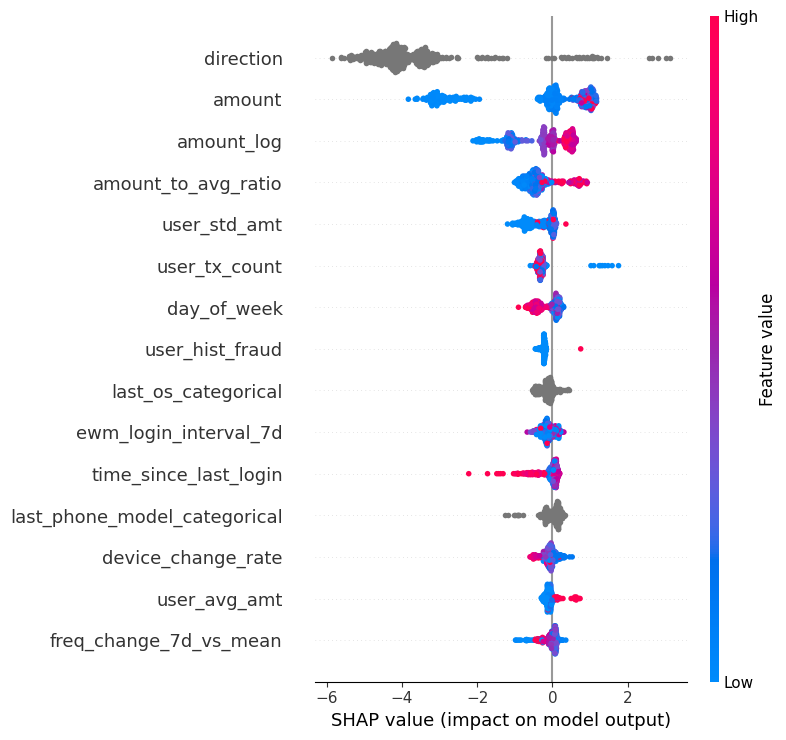

In [4]:
# prepare data for SHAP
X_sample = df[feature_names].head(500)

# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# summary plot
shap.summary_plot(shap_values, X_sample, max_display=15, show=True)

## 4. Анализ конкретной транзакции

In [7]:
def analyze_transaction(idx):
    """Analyze a specific transaction with SHAP."""
    row = df.iloc[idx]
    X_single = df[feature_names].iloc[[idx]]
    
    # prediction
    prob = model.predict_proba(X_single)[0, 1]
    pred = int(prob >= 0.80)
    
    print("=" * 50)
    print(f"TRANSACTION #{idx}")
    print("=" * 50)
    print(f"Actual:      {'FRAUD' if row['target'] == 1 else 'LEGIT'}")
    print(f"Predicted:   {'FRAUD' if pred == 1 else 'LEGIT'}")
    print(f"Probability: {prob:.1%}")
    print(f"Scorecard:   {row.get('scorecard_total', 'N/A')}")
    print("-" * 50)
    
    # SHAP for this transaction
    shap_single = explainer.shap_values(X_single)
    
    # top contributing features
    contributions = pd.DataFrame({
        'feature': feature_names,
        'value': X_single.values[0],
        'shap': shap_single[0]
    }).sort_values('shap', key=abs, ascending=False).head(10)
    
    print("Top factors:")
    for _, r in contributions.iterrows():
        direction = '+' if r['shap'] > 0 else '-'
        val = r['value']
        val_str = f"{val:.2f}" if isinstance(val, (int, float, np.floating)) else str(val)
        print(f"  {direction} {r['feature']}: {val_str} (SHAP: {r['shap']:+.3f})")
    
    return shap_single

# analyze a fraud case
fraud_indices = df[df['target'] == 1].index.tolist()
if fraud_indices:
    shap_vals = analyze_transaction(fraud_indices[0])

TRANSACTION #230
Actual:      FRAUD
Predicted:   LEGIT
Probability: 48.6%
Scorecard:   7
--------------------------------------------------
Top factors:
  + direction: 26918a5242f0425ed83663743ba4a00b (SHAP: +2.566)
  + amount: 40000.00 (SHAP: +0.923)
  - amount_to_avg_ratio: 0.71 (SHAP: -0.607)
  - user_tx_count: 64.00 (SHAP: -0.433)
  + amount_log: 10.60 (SHAP: +0.415)
  - burstiness_login_interval: -0.05 (SHAP: -0.341)
  - user_hist_fraud: 0.00 (SHAP: -0.338)
  - var_login_interval_30d: 2825871393.31 (SHAP: -0.318)
  - ewm_login_interval_7d: 100965.16 (SHAP: -0.290)
  - last_os_categorical: Android/13 (SHAP: -0.196)


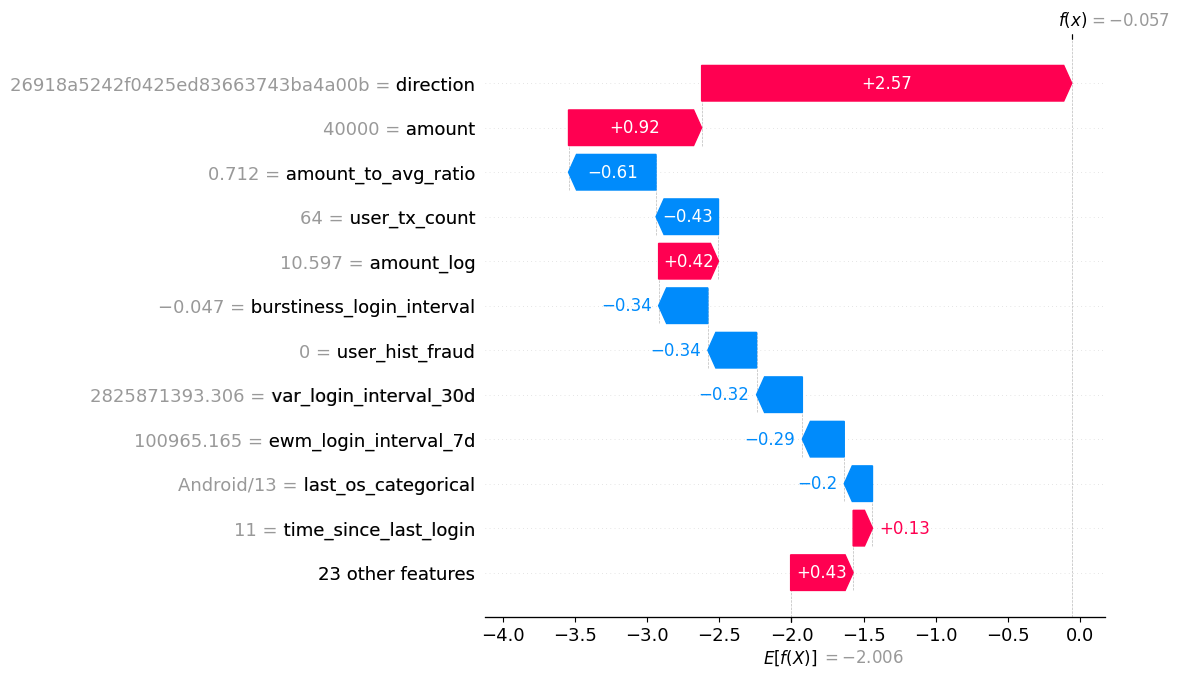

In [8]:
# waterfall plot for the transaction
if fraud_indices:
    idx = fraud_indices[0]
    X_single = df[feature_names].iloc[[idx]]
    shap_single = explainer(X_single)
    shap.plots.waterfall(shap_single[0], max_display=12)

## 5. Влияние порога на метрики

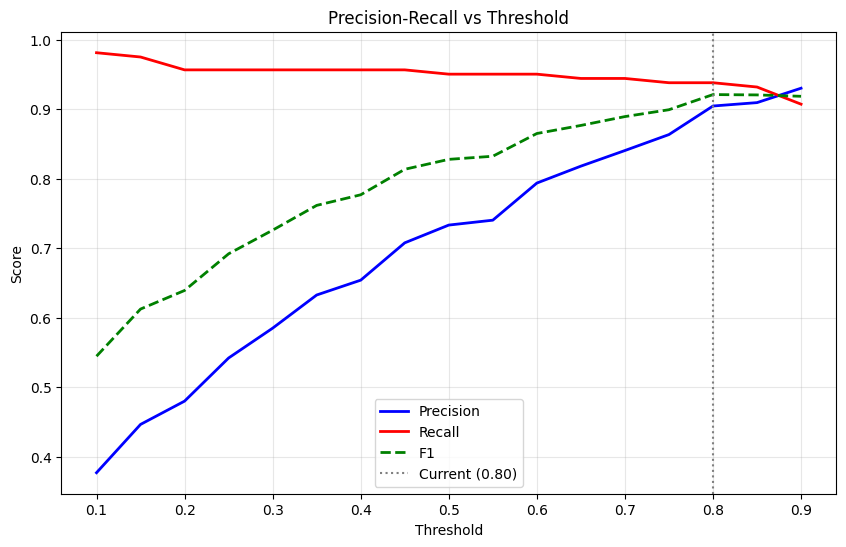

 threshold  precision   recall       f1  tp  fp  fn
      0.10   0.376777 0.981481 0.544521 159 263   3
      0.15   0.446328 0.975309 0.612403 158 196   4
      0.20   0.479876 0.956790 0.639175 155 168   7
      0.25   0.541958 0.956790 0.691964 155 131   7
      0.30   0.584906 0.956790 0.725995 155 110   7
      0.35   0.632653 0.956790 0.761671 155  90   7
      0.40   0.654008 0.956790 0.776942 155  82   7
      0.45   0.707763 0.956790 0.813648 155  64   7
      0.50   0.733333 0.950617 0.827957 154  56   8
      0.55   0.740385 0.950617 0.832432 154  54   8
      0.60   0.793814 0.950617 0.865169 154  40   8
      0.65   0.818182 0.944444 0.876791 153  34   9
      0.70   0.840659 0.944444 0.889535 153  29   9
      0.75   0.863636 0.938272 0.899408 152  24  10
      0.80   0.904762 0.938272 0.921212 152  16  10
      0.85   0.909639 0.932099 0.920732 151  15  11
      0.90   0.930380 0.907407 0.918750 147  11  15


In [9]:
import matplotlib.pyplot as plt

# get probabilities for ML-checked transactions
df_ml = df[df['scorecard_total'] > 1].copy()
y_true_ml = df_ml['target']
y_prob_ml = df_ml['fraud_probability']

thresholds = np.arange(0.1, 0.95, 0.05)
results = []

for thresh in thresholds:
    y_pred_t = (y_prob_ml >= thresh).astype(int)
    tp_t = ((y_true_ml == 1) & (y_pred_t == 1)).sum()
    fp_t = ((y_true_ml == 0) & (y_pred_t == 1)).sum()
    fn_t = ((y_true_ml == 1) & (y_pred_t == 0)).sum()
    
    prec = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
    rec = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    f1_t = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    results.append({'threshold': thresh, 'precision': prec, 'recall': rec, 'f1': f1_t, 'tp': tp_t, 'fp': fp_t, 'fn': fn_t})

df_thresh = pd.DataFrame(results)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_thresh['threshold'], df_thresh['precision'], 'b-', label='Precision', linewidth=2)
ax.plot(df_thresh['threshold'], df_thresh['recall'], 'r-', label='Recall', linewidth=2)
ax.plot(df_thresh['threshold'], df_thresh['f1'], 'g--', label='F1', linewidth=2)
ax.axvline(x=0.80, color='gray', linestyle=':', label='Current (0.80)')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision-Recall vs Threshold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print(df_thresh[['threshold', 'precision', 'recall', 'f1', 'tp', 'fp', 'fn']].to_string(index=False))

## 6. Feature Importance

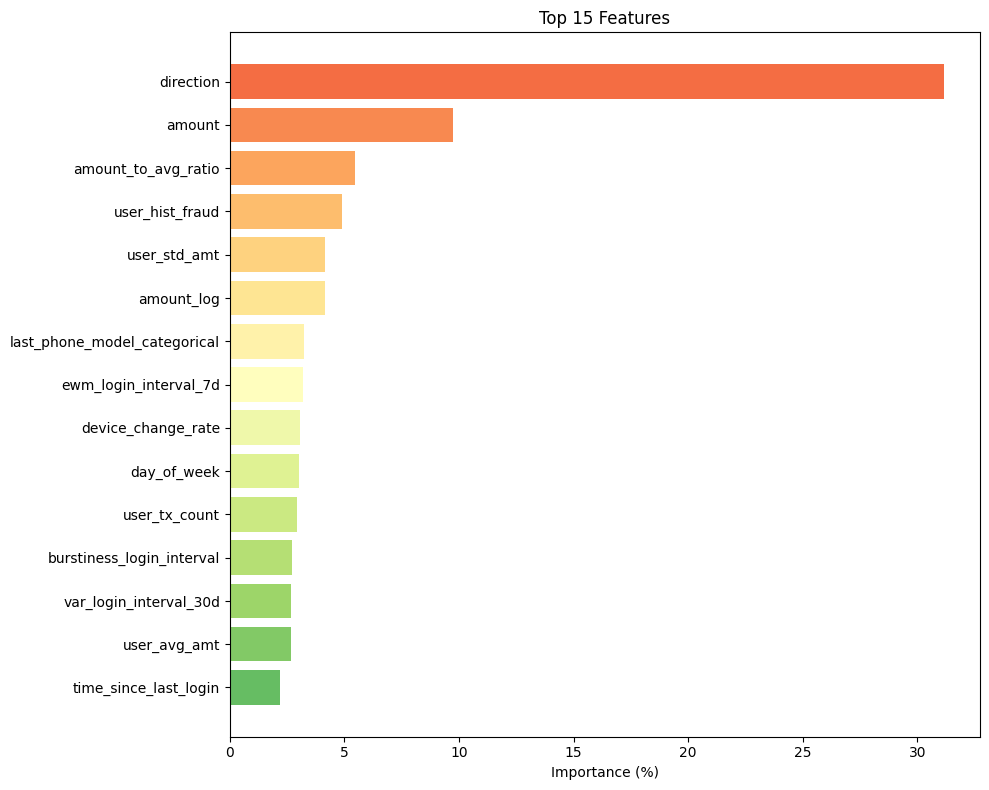

In [10]:
# feature importance from model
importance = model.get_feature_importance()
fi = pd.DataFrame({'feature': feature_names, 'importance': importance})
fi = fi.sort_values('importance', ascending=True).tail(15)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(fi)))
ax.barh(fi['feature'], fi['importance'], color=colors)
ax.set_xlabel('Importance (%)')
ax.set_title('Top 15 Features')
plt.tight_layout()
plt.show()

## 7. Скорость обработки

In [11]:
import time

X_bench = df[feature_names].head(1000)

# benchmark
start = time.perf_counter()
for _ in range(10):
    _ = model.predict_proba(X_bench)
elapsed = time.perf_counter() - start

total_predictions = 10 * 1000
tps = total_predictions / elapsed
latency_ms = (elapsed / total_predictions) * 1000

print("=" * 40)
print("SPEED BENCHMARK")
print("=" * 40)
print(f"Throughput: {tps:,.0f} TPS")
print(f"Latency:    {latency_ms:.3f} ms/transaction")
print(f"Real-time:  {'YES' if latency_ms < 10 else 'NO'}")
print("=" * 40)

SPEED BENCHMARK
Throughput: 267,694 TPS
Latency:    0.004 ms/transaction
Real-time:  YES
